In [ ]:
!pip install python-louvain
!pip install infomap
!pip install pyreadr
!pip install leidenalg
!pip install cdlib
!pip install leidenalg
!pip install pyreadr
!pip install cdlib networkx python-louvain leidenalg infomap pandas

# Data Loading and Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
import igraph as ig
from networkx.algorithms import bipartite
from scipy import integrate
import pyreadr
import matplotlib.pyplot as plt
import copy
import community as community_louvain
from infomap import Infomap
from collections import defaultdict
from scipy.stats import zscore
from cdlib import algorithms
import leidenalg
import math
import os
import pickle
from cdlib import algorithms, evaluation, NodeClustering

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer'}


In [ ]:
# Define a list of potential working directory paths on Google Drive
potential_working_directories = [
    '/content/drive/MyDrive/Data Science/Data Driven', 
    '/content/drive/MyDrive/Data Driven',   
    '/content/drive/MyDrive',                 
    ]

selected_working_directory = None

for path in potential_working_directories:
    if os.path.exists(path):
        selected_working_directory = path
        print(f"Found working directory at: {path}")
        break
    else:
        print(f"Working directory not found at: {path}")

if selected_working_directory:
    # Change the current working directory
    os.chdir(selected_working_directory)
    # Verify the new working directory
    print(f"Current working directory: {os.getcwd()}")
else:
    raise FileNotFoundError("Could not find a suitable working directory from the specified paths.")


Working directory not found at: /content/drive/MyDrive/Data Science/Data Driven
Found working directory at: /content/drive/MyDrive/Data Driven
Current working directory: /content/drive/.shortcut-targets-by-id/17ajxqNmNMSmblVtm1Xc8cvXE9UFH4MNM/Data Driven


In [ ]:
df= pd.read_csv('rec-amazon-ratings.edges', header=None)

## Data cleaning

In [ ]:
df.columns = ['V1', 'V2', 'V3', 'V4']

# Create 'user_id' by converting V1 to integer
df['user_id'] = df['V1'].astype(int)

# Create 'product_id' by converting V2 to integer
df['product_id'] =  df['V2'].astype(int)

# Create 'review' column from V3
df['review'] = df['V3']

# Convert V4 from Unix timestamp to datetime
df['time'] = pd.to_datetime(df['V4'], unit='s')

## Data Filtering

In [ ]:
# Filter dataframe for entries from the year 2006
df['year'] = pd.to_datetime(df['time']).dt.year
df_2006 = df[df['year'].isin([2006])]

# Exploratory Analysis

In [ ]:
# Calculate number of reviews per user in 2006
reviews_per_user_2006 = df_2006.groupby('user_id').size()

# Calculate number of reviews per product in 2006
reviews_per_product_2006 = df_2006.groupby('product_id').size()

# Calculate rating distribution for 2006
rating_dist_2006 = df_2006['review'].value_counts().sort_index()

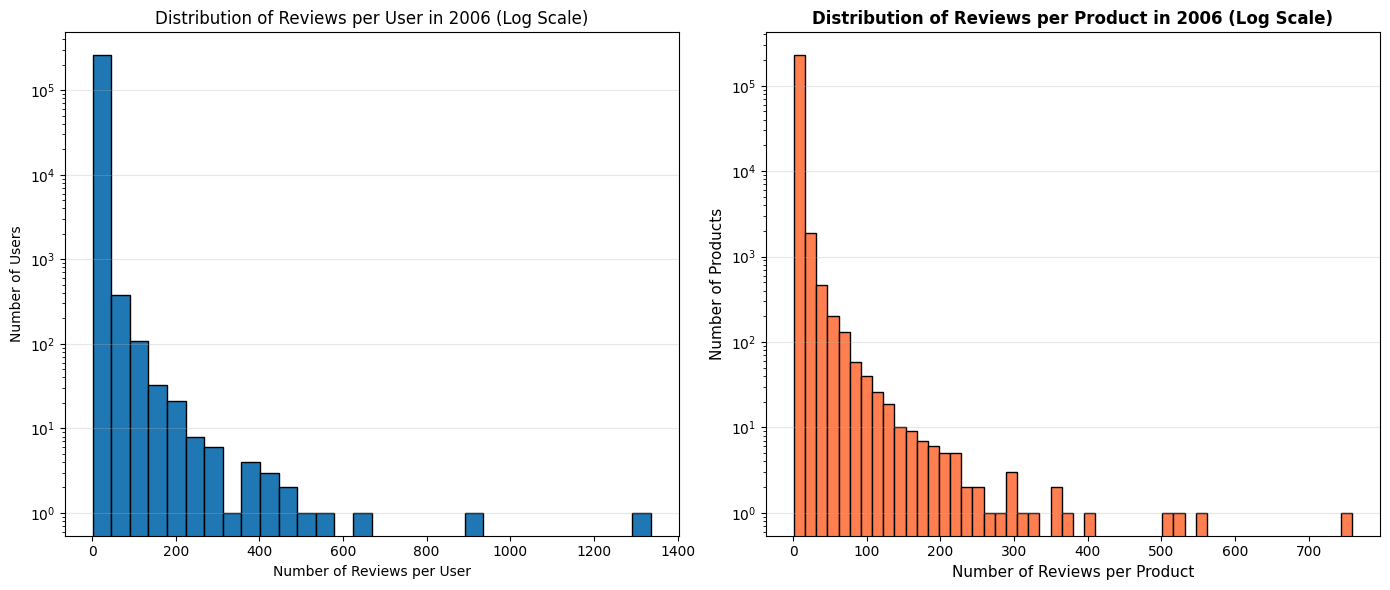

In [ ]:
# Plot histograms for reviews per user and reviews per product in 2006
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: reviews per user
axes[0].hist(reviews_per_user_2006, bins=30, edgecolor='black', log=True)
axes[0].set_xlabel('Number of Reviews per User')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Reviews per User in 2006 (Log Scale)')
axes[0].grid(axis='y', alpha=0.3)

# Second plot: reviews per product
axes[1].hist(reviews_per_product_2006, bins=50, color='coral', edgecolor='black', log=True)
axes[1].set_xlabel('Number of Reviews per Product', fontsize=11)
axes[1].set_ylabel('Number of Products', fontsize=11)
axes[1].set_title('Distribution of Reviews per Product in 2006 (Log Scale)', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

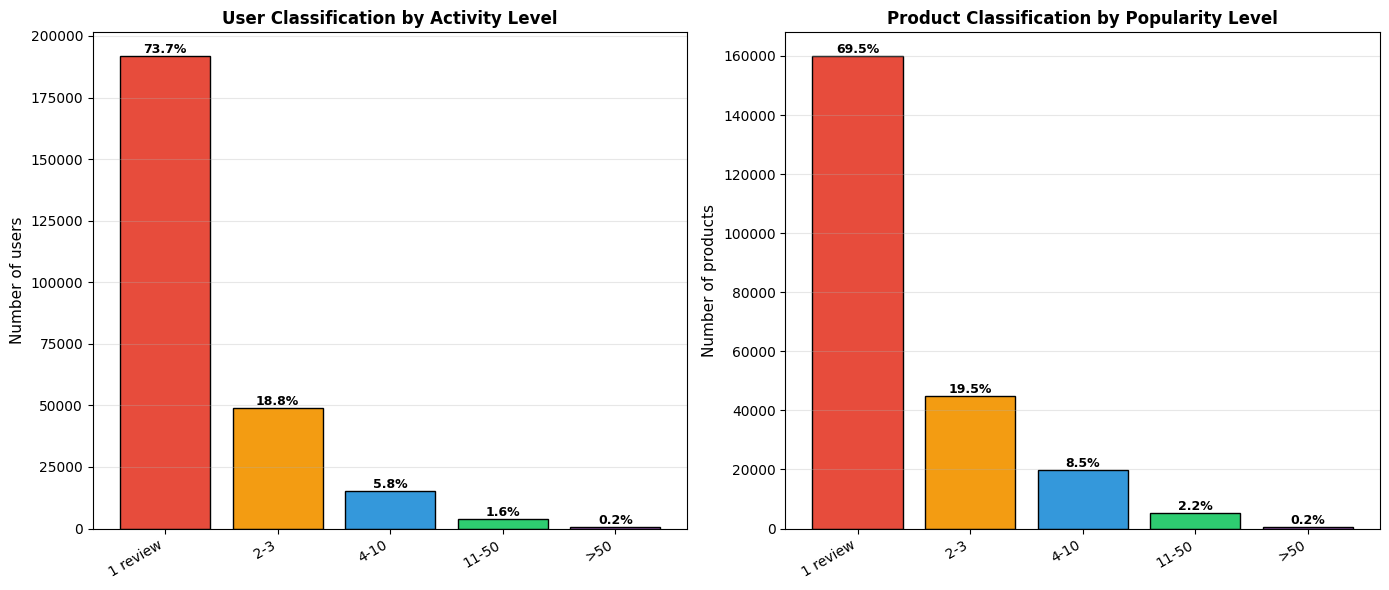

In [ ]:
# Create subplots for user and product classification
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Classify users based on number of reviews in 2006
bins = [0, 1, 3, 10, 50, float('inf')]
labels = ['1 review', '2-3', '4-10', '11-50', '>50']
user_categories = pd.cut(reviews_per_user_2006, bins=bins, labels=labels, right=True)
category_counts = user_categories.value_counts()

colors_cat = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71', '#9b59b6']
axes[0].bar(range(len(category_counts)), category_counts.values, color=colors_cat, edgecolor='black')
axes[0].set_xticks(range(len(category_counts)))
axes[0].set_xticklabels(category_counts.index, rotation=30, ha='right')
axes[0].set_ylabel('Number of users', fontsize=11)
axes[0].set_title('User Classification by Activity Level', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add percentages on bars
for i, (count, label) in enumerate(zip(category_counts.values, category_counts.index)):
    pct = count / len(reviews_per_user_2006) * 100
    axes[0].text(i, count, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')


# Classify products based on number of reviews in 2006
product_categories = pd.cut(reviews_per_product_2006, bins=bins, labels=labels, right=True)
category_counts_prod = product_categories.value_counts()

colors_prod = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71', '#9b59b6']
axes[1].bar(range(len(category_counts_prod)), category_counts_prod.values, color=colors_prod, edgecolor='black')
axes[1].set_xticks(range(len(category_counts_prod)))
axes[1].set_xticklabels(category_counts_prod.index, rotation=30, ha='right')
axes[1].set_ylabel('Number of products', fontsize=11)
axes[1].set_title('Product Classification by Popularity Level', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add percentages on bars
for i, (count, label) in enumerate(zip(category_counts_prod.values, category_counts_prod.index)):
    pct = count / len(reviews_per_product_2006) * 100
    axes[1].text(i, count, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# Compute rating variance per product (only products with at least 5 reviews)
product_stats_2006 = df_2006.groupby('product_id')['review'].agg(['mean', 'std', 'count'])
product_stats_2006 = product_stats_2006[product_stats_2006['count'] >= 5]

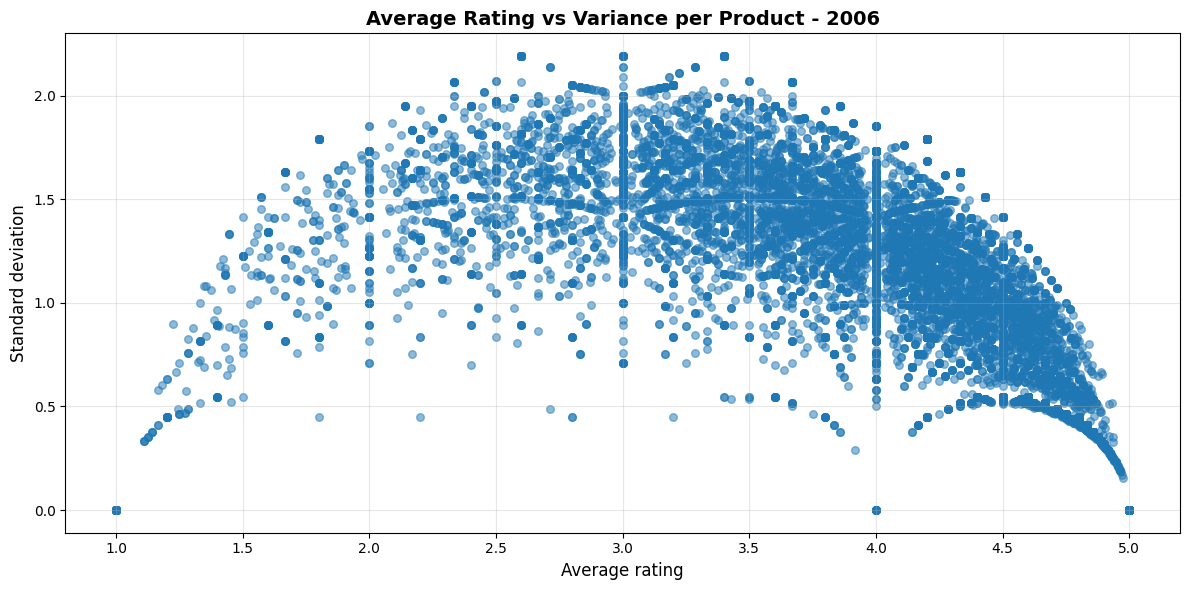

In [ ]:
# Scatter plot: mean vs variance
plt.figure(figsize=(12, 6))
plt.scatter(product_stats_2006['mean'], product_stats_2006['std'], alpha=0.5, s=30)
plt.xlabel('Average rating', fontsize=12)
plt.ylabel('Standard deviation', fontsize=12)
plt.title('Average Rating vs Variance per Product - 2006', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Analyze behavior: compare very active users vs casual users
very_active_users = reviews_per_user_2006[reviews_per_user_2006 > reviews_per_user_2006.quantile(0.90)].index
casual_users = reviews_per_user_2006[reviews_per_user_2006 <= 3].index
# active if have more reviews than 90th percentile, casual if 3 or fewer reviews

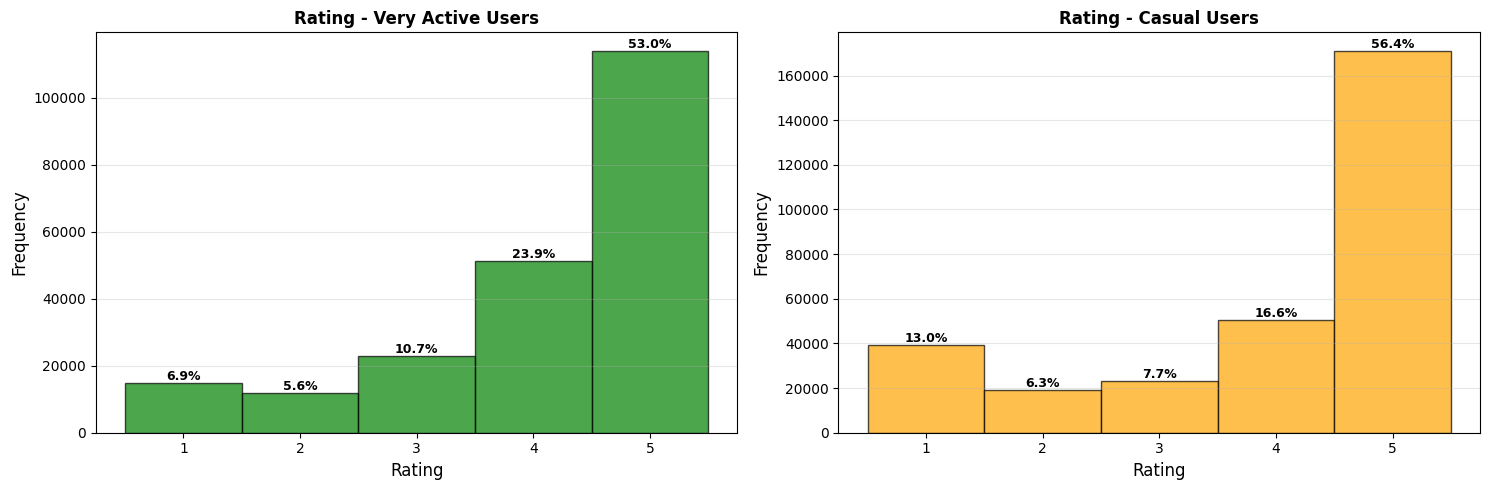

In [ ]:
# Plot histograms of ratings for very active users vs casual users
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Very active users
counts_active, bin_edges_active = np.histogram(df_2006[df_2006['user_id'].isin(very_active_users)]['review'], bins=bins)
total_active = counts_active.sum()
axes[0].bar(bin_edges_active[:-1], counts_active, width=np.diff(bin_edges_active), color='green', alpha=0.7, edgecolor='black', align='edge')
axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Rating - Very Active Users', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, count in enumerate(counts_active):
    pct = (count / total_active) * 100 if total_active > 0 else 0
    axes[0].text(bin_edges_active[i] + (bin_edges_active[i+1] - bin_edges_active[i])/2, count, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Casual users
counts_casual, bin_edges_casual = np.histogram(df_2006[df_2006['user_id'].isin(casual_users)]['review'], bins=bins)
total_casual = counts_casual.sum()
axes[1].bar(bin_edges_casual[:-1], counts_casual, width=np.diff(bin_edges_casual), color='orange', alpha=0.7, edgecolor='black', align='edge')
axes[1].set_xlabel('Rating', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Rating - Casual Users', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, count in enumerate(counts_casual):
    pct = (count / total_casual) * 100 if total_casual > 0 else 0
    axes[1].text(bin_edges_casual[i] + (bin_edges_casual[i+1] - bin_edges_casual[i])/2, count, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
num_users_2006 = df_2006['user_id'].nunique()
num_products_2006 = df_2006['product_id'].nunique()

In [ ]:
print("=" * 70)
print("Summary Analysis 2006".center(70))
print("=" * 70)

print("\n📊 GENERAL DATA")
print(f"  • Total reviews: {len(df_2006):,}")
print(f"  • Unique users: {num_users_2006:,}")
print(f"  • Unique products: {num_products_2006:,}")
print(f"  • Average rating: {df_2006['review'].mean():.2f}")

print("\n⭐ RATING DISTRIBUTION")
for rating in sorted(df_2006['review'].unique()):
    count = len(df_2006[df_2006['review'] == rating])
    pct = count / len(df_2006) * 100
    print(f"  • {rating} stars: {count:,} ({pct:.1f}%)")
print("\n👥 USER STATISTICS")
print(f"  • Average reviews/user: {reviews_per_user_2006.mean():.2f}")
print(f"  • Users with 1 review: {(reviews_per_user_2006 == 1).sum():,} ({(reviews_per_user_2006 == 1).sum()/len(reviews_per_user_2006)*100:.1f}%)")
print(f"  • Users with >10 reviews: {(reviews_per_user_2006 > 10).sum():,} ({(reviews_per_user_2006 > 10).sum()/len(reviews_per_user_2006)*100:.1f}%)")
print("\n📦 PRODUCT STATISTICS")
print(f"  • Average reviews/product: {reviews_per_product_2006.mean():.2f}")
print(f"  • Products with 1 review: {(reviews_per_product_2006 == 1).sum():,} ({(reviews_per_product_2006 == 1).sum()/len(reviews_per_product_2006)*100:.1f}%)")
print(f"  • Products with >20 reviews: {(reviews_per_product_2006 > 20).sum():,} ({(reviews_per_product_2006 > 20).sum()/len(reviews_per_product_2006)*100:.1f}%)")

print("\n" + "=" * 70)

                        Summary Analysis 2006                         

📊 GENERAL DATA
  • Total reviews: 517,684
  • Unique users: 260,349
  • Unique products: 230,332
  • Average rating: 4.03

⭐ RATING DISTRIBUTION
  • 1.0 stars: 54,137 (10.5%)
  • 2.0 stars: 30,929 (6.0%)
  • 3.0 stars: 46,369 (9.0%)
  • 4.0 stars: 101,551 (19.6%)
  • 5.0 stars: 284,698 (55.0%)

👥 USER STATISTICS
  • Average reviews/user: 1.99
  • Users with 1 review: 191,878 (73.7%)
  • Users with >10 reviews: 4,523 (1.7%)

📦 PRODUCT STATISTICS
  • Average reviews/product: 2.25
  • Products with 1 review: 160,007 (69.5%)
  • Products with >20 reviews: 2,062 (0.9%)



# Graph Analysis

## Initialization

In [ ]:
# Create an empty graph
G = nx.Graph()

# Add nodes for users with bipartite attribute 0
users = df_2006['user_id'].unique()
G.add_nodes_from(users, bipartite=0)

# Add nodes for products with bipartite attribute 1
products = df_2006['product_id'].unique()
G.add_nodes_from(products, bipartite=1)

# Add edges from the DataFrame
# Iterate through each row and add an edge with 'review' and 'time' attributes
for _, row in df_2006.iterrows():
    G.add_edge(row['user_id'], row['product_id'], review=row['review'], time=row['time'])

In [ ]:
try:
    with open('user_projection.gpickle', 'rb') as f:
        user_projection = pickle.load(f)
except FileNotFoundError:
    # Project the graph
    user_projection = bipartite.projected_graph(G, users)

    # Add the weight to the edges
    for u, v in user_projection.edges():
        user_projection[u][v]["weight"] = len(
            set(G[u]) & set(G[v])
        )

In [ ]:
# number of nodes
num_nodes_nobb = user_projection.number_of_nodes()
print(f"Number of nodes in user projection after the filtering: {num_nodes_nobb}")

# number of edges
num_edges_nobb = user_projection.number_of_edges()
print(f"Number of edges in user projection: {num_edges_nobb}")

# average degree
avg_degree_nobb = sum(dict(user_projection.degree()).values()) / num_nodes_nobb
print(f"Average degree in user projection: {avg_degree_nobb:.2f}")

# comparison with log of Nodes
print(f"Log of number of nodes: {np.log(num_nodes_nobb):.2f}")

# supercritical regime status
if avg_degree_nobb > np.log(num_nodes_nobb):
    print("The user projection is in the supercritical regime.")

# average of strength
avg_strength_nobb = sum(dict(user_projection.degree(weight='weight')).values()) / num_nodes_nobb
print(f"Average strength in user projection: {avg_strength_nobb:.2f}")

# standard deviation of degree
degrees_nobb = np.array(list(dict(user_projection.degree()).values()))
std_degree_nobb = np.std(degrees_nobb)
print(f"Standard deviation of degree in user projection: {std_degree_nobb:.2f}")


Number of nodes in user projection after the filtering: 375494
Number of edges in user projection: 6690400
Average degree in user projection: 35.64
Log of number of nodes: 12.84
The user projection is in the supercritical regime.
Average strength in user projection: 36.36
Standard deviation of degree in user projection: 112.33


## Backbone filtering

In [ ]:

# We compute two "strengths" per node:
# - positive strength: sum of positive weights
# - negative strength: sum of absolute value of negative weights
strengths_pos = {n: 0.0 for n in user_projection.nodes()}
strengths_neg = {n: 0.0 for n in user_projection.nodes()}

for u, v, data in user_projection.edges(data=True):
    w = data.get('weight', 0.0)
    if w >= 0:
        strengths_pos[u] += w
        strengths_pos[v] += w
    else:
        strengths_neg[u] += abs(w)
        strengths_neg[v] += abs(w)

# Compute unweighted degrees for each node separately for positive and negative edges
degrees_pos = {n: 0 for n in user_projection.nodes()}
degrees_neg = {n: 0 for n in user_projection.nodes()}

for u, v, data in user_projection.edges(data=True):
    w = data.get('weight', 0.0)
    if w >= 0:
        degrees_pos[u] += 1
        degrees_pos[v] += 1
    else:
        degrees_neg[u] += 1
        degrees_neg[v] += 1

# Keep these names (even if we don't use them directly later) to avoid changing your variable names
strengths = dict(user_projection.degree(weight='weight'))
degrees = dict(user_projection.degree())

# Normalize the weight of each edge by the appropriate (positive/negative) strengths of both its nodes
# For negative Pearson, we normalize using abs(weight) over negative-strength (sum of abs negative weights)
for u, v, data in user_projection.edges(data=True):
    w = data.get('weight', 0.0)

    if w >= 0:
        su = strengths_pos[u]
        sv = strengths_pos[v]
        wu = w
        wv = w
    else:
        su = strengths_neg[u]
        sv = strengths_neg[v]
        wu = abs(w)
        wv = abs(w)

    # Avoid division by zero (can happen if a node has no strength of that sign)
    data['normalized_weight_u'] = (wu / su) if su > 0 else 0.0
    data['normalized_weight_v'] = (wv / sv) if sv > 0 else 0.0

# Compute local p values for each edge using the appropriate degree (positive/negative) for each endpoint
for u, v, data in user_projection.edges(data=True):
    w = data.get('weight', 0.0)

    if w >= 0:
        ku = degrees_pos[u]
        kv = degrees_pos[v]
    else:
        ku = degrees_neg[u]
        kv = degrees_neg[v]

    # Disparity filter formula: alpha = (1 - p)^(k-1)
    # If k <= 1, set alpha to 1.0 (no statistical leverage on a single edge)
    p_u = data['normalized_weight_u']
    p_v = data['normalized_weight_v']

    data['alpha_uv'] = (1.0 - p_u) ** (ku - 1) if ku > 1 else 1.0
    data['alpha_vu'] = (1.0 - p_v) ** (kv - 1) if kv > 1 else 1.0

# Define the significance threshold
alpha_sig = 0.05

# Filter edges: keep only those where the minimum of alpha_uv and alpha_vu is less than alpha_sig
edges_to_remove = []
for u, v, data in user_projection.edges(data=True):
    alpha_min = min(data['alpha_uv'], data['alpha_vu'])
    if alpha_min >= alpha_sig:
        edges_to_remove.append((u, v))

# Remove the edges that do not meet the significance criterion by creating a copy of the graph
filtered_user_projection = user_projection.copy()
filtered_user_projection.remove_edges_from(edges_to_remove)

In [ ]:
user_projection = filtered_user_projection

## Metrics Analysis

In [ ]:
# number of nodes
num_nodes = user_projection.number_of_nodes()
print(f"Number of nodes in user projection after the filtering: {num_nodes}")

# number of edges
num_edges = user_projection.number_of_edges()
print(f"Number of edges in user projection after the filtering: {num_edges}")
# average degree
avg_degree = sum(dict(user_projection.degree()).values()) / num_nodes
print(f"Average degree in user projection after the filtering: {avg_degree:.2f}")

# comparison with log of Nodes
print(f"Log of number of nodes after the filtering: {np.log(num_nodes):.2f}")

# supercritical regime status
if avg_degree > np.log(num_nodes):
    print("The user projection is in the supercritical regime after the filtering.")

# average of strength
avg_strength = sum(dict(user_projection.degree(weight='weight')).values()) / num_nodes
print(f"Average strength in user projection after the filtering: {avg_strength:.2f}")
# standard deviation of degree
degrees = np.array(list(dict(user_projection.degree()).values()))
std_degree = np.std(degrees)
print(f"Standard deviation of degree in user projection after the filtering: {std_degree:.2f}")

# sparse density
sparse_density = nx.density(user_projection)
print(f"Sparse density in user projection after the filtering: {sparse_density:.6f}")
# average clustering coefficient
avg_clustering = nx.average_clustering(user_projection)
print(f"Average clustering coefficient in user projection after the filtering: {avg_clustering:.4f}")

# modularity using Louvain method
partition = community_louvain.best_partition(user_projection, weight='weight')
modularity = community_louvain.modularity(partition, user_projection, weight='weight')
print(f"Modularity of user projection (Louvain) after the filtering: {modularity:.4f}")

Number of nodes in user projection after the filtering: 375494
Number of edges in user projection after the filtering: 6690400
Average degree in user projection after the filtering: 35.64
Log of number of nodes after the filtering: 12.84
The user projection is in the supercritical regime after the filtering.
Average strength in user projection after the filtering: 36.36
Standard deviation of degree in user projection after the filtering: 112.33


'\n# sparse density\nsparse_density = nx.density(user_projection)\nprint(f"Sparse density in user projection after the filtering: {sparse_density:.6f}")\n# average clustering coefficient\navg_clustering = nx.average_clustering(user_projection)\nprint(f"Average clustering coefficient in user projection after the filtering: {avg_clustering:.4f}")\n\n# modularity using Louvain method\npartition = community_louvain.best_partition(user_projection, weight=\'weight\')\nmodularity = community_louvain.modularity(partition, user_projection, weight=\'weight\')\nprint(f"Modularity of user projection (Louvain) after the filtering: {modularity:.4f}")\n'

## Power Law Fit

Estimated power-law exponent: 1.34


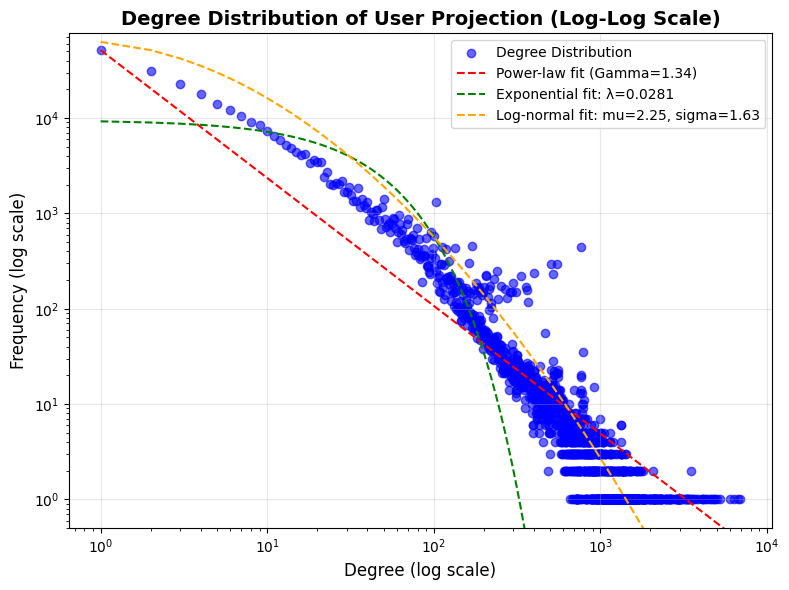

In [ ]:
# Compute and plot degree distribution
degree_sequence = sorted([d for n, d in user_projection.degree()], reverse=True)
degree_count = np.bincount(degree_sequence)

# Compute Power law exponent
degrees = np.array(degree_sequence)
degrees = degrees[degrees > 0]  # Remove zero degrees for fitting
# Compute the exponent
Lambda = 1 + len(degrees) / np.sum(np.log(degrees / (np.min(degrees) - 0.5)))
print(f"Estimated power-law exponent: {Lambda:.2f}")

# Plot degree distribution in a scatterplot and compare with power-law fit
plt.figure(figsize=(8, 6))
plt.scatter(range(len(degree_count)), degree_count, color='blue', alpha=0.6, label='Degree Distribution')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Degree (log scale)', fontsize=12)
plt.ylabel('Frequency (log scale)', fontsize=12)
plt.title('Degree Distribution of User Projection (Log-Log Scale)', fontsize=14, fontweight='bold')
# Power-law fit line
x = np.array(range(1, len(degree_count)))
y = x ** (-Lambda) * degree_count[1]  # Scale to match the first point
plt.plot(x, y, color='red', linestyle='--', label=f'Power-law fit (Gamma={Lambda:.2f})')
# Exponential fit line
lambda_exp = 1 / avg_degree
k_values = np.arange(1, len(degree_count))
pdf_exp = np.exp(-lambda_exp * k_values)
scale_factor = len(degrees) / np.sum(pdf_exp)
y_exp = pdf_exp * scale_factor
plt.plot(k_values, y_exp, color='green', linestyle='--',  label=f'Exponential fit: λ={lambda_exp:.4f}')
# Log normal fit line
# Mu and sigma for log-normal
mu = np.mean(np.log(degrees))
sigma = np.std(np.log(degrees))
# Log-normal fit line
y_log_normal = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(- (np.log(x) - mu) ** 2 / (2 * sigma ** 2))
y_log_normal *= degree_count[1] / y_log_normal[1]  # Scale to match the first point
plt.plot(x, y_log_normal, color='orange', linestyle='--', label='Log-normal fit: mu={:.2f}, sigma={:.2f}'.format(mu, sigma))
plt.ylim(bottom=0.5,top = degree_count.max()*1.5)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Comparison with Random Graph

In [ ]:
try:
    with open('user_projection_random.gpickle', 'rb') as f:
        user_projection_random = pickle.load(f)
except FileNotFoundError:
  # copy graph for randomization
  user_projection_random = user_projection.copy()

  # Perform double edge swaps to randomize the graph while preserving degree distribution
  nx.double_edge_swap(user_projection_random, nswap=5*user_projection.number_of_edges(), max_tries=100*user_projection.number_of_edges())


In [ ]:
num_nodes_random = user_projection_random.number_of_nodes()
num_edges_random = user_projection_random.number_of_edges()
average_degree_random = sum(dict(user_projection_random.degree()).values()) / num_nodes_random
standard_deviation_degree_random = np.sqrt(average_degree_random)
average_clustering_random = nx.average_clustering(user_projection_random)
modularity_random = community_louvain.modularity(community_louvain.best_partition(user_projection_random, weight='weight'), user_projection_random, weight='weight')

"\naverage_clustering_random = nx.average_clustering(user_projection_random)\nmodularity_random = community_louvain.modularity(community_louvain.best_partition(user_projection_random, weight='weight'), user_projection_random, weight='weight')\n"

In [ ]:
# table comparison between original and randomized graph
print("\nComparison between Original and Randomized User Projection Graphs:")
print(f"{'Measure':<35} {'Original':<15} {'Randomized':<15}")
print(f"{'-'*65}")
print(f"{'Number of nodes':<35} {num_nodes:<15} {num_nodes_random:<15}")
print(f"{'Number of edges':<35} {num_edges:<15} {num_edges_random:<15}")
print(f"{'Average degree':<35} {avg_degree:<15.2f} {average_degree_random:<15.2f}")
print(f"{'Standard deviation of degree':<35} {std_degree:<15.2f} {standard_deviation_degree_random:<15.2f}")
print(f"{'Average clustering coefficient':<35} {avg_clustering:<15.4f} {average_clustering_random:<15.4f}")
print(f"{'Modularity (Louvain)':<35} {modularity:<15.4f} {modularity_random:<15.4f}")


Comparison between Original and Randomized User Projection Graphs:
Measure                             Original        Randomized     
-----------------------------------------------------------------
Number of nodes                     375494          375494         
Number of edges                     7742            7742           
Average degree                      0.04            0.04           
Standard deviation of degree        1.27            0.20           


'\nprint(f"{\'Average clustering coefficient\':<35} {avg_clustering:<15.4f} {average_clustering_random:<15.4f}")\nprint(f"{\'Modularity (Louvain)\':<35} {modularity:<15.4f} {modularity_random:<15.4f}")\n'

## Pearson Coefficient Computation

In [ ]:
threshold = 5

In [ ]:
try:
    with open('user_projection_con_pearson.gpickle', 'rb') as f:
        user_projection = pickle.load(f)
except FileNotFoundError:
  # Computation of Pearson correlation coefficient (Pearson) between user pairs in the user projection graph
  for u,v,d in user_projection.edges(data = True):

      # Get common products reviewed by both users
      common_products = set(G[u]) & set(G[v])

      # Build rating vectors
      r1 = [G[u][p]['review'] for p in common_products if 'review' in G[u][p]]
      r2 = [G[v][p]['review'] for p in common_products if 'review' in G[v][p]]

      pear = float('nan')
      if len(r1)>= threshold:
          r1_arr = np.array(r1)
          r2_arr = np.array(r2)
          if np.std(r1_arr) > 0 and np.std(r2_arr) > 0:
              pear = float(np.corrcoef(r1_arr, r2_arr)[0, 1])


      # Assign Pearson correlation as edge attribute
      user_projection[u][v]['pearson'] = pear


### Pearson Coefficient Analysis

In [ ]:
# stored Pearson values and weights in a DataFrame
pearson_values = []
for u, v, d in user_projection.edges(data=True):
    pearson_values.append({'pearson': d['pearson'], 'weight': d['weight']})
pearson_df = pd.DataFrame(pearson_values)

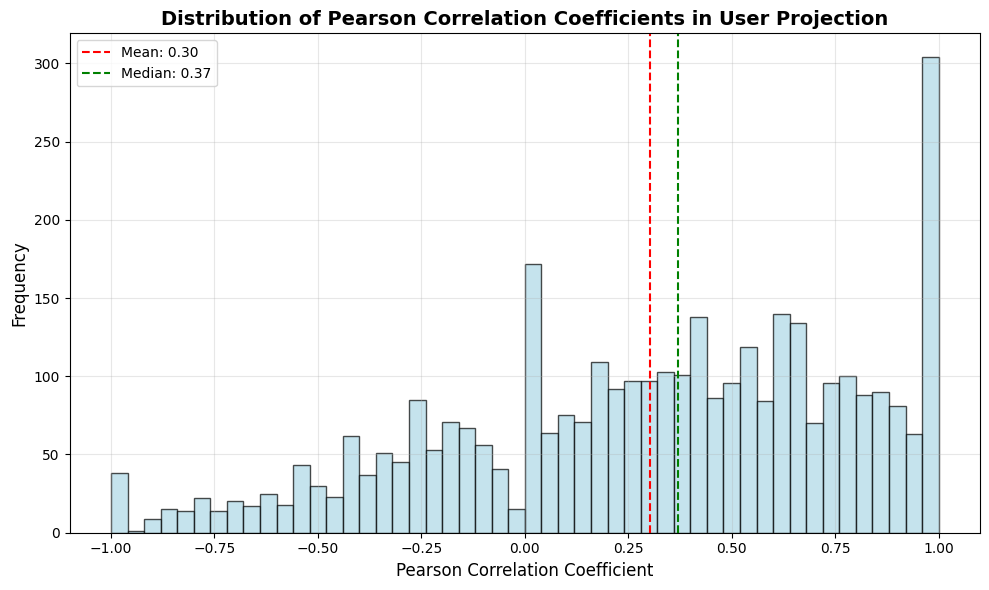

In [ ]:
# Plot histogram of Pearson correlation coefficients and adding average and median lines
plt.figure(figsize=(10, 6))
plt.hist(pearson_df['pearson'].dropna(), bins=50, color='lightblue', edgecolor='black', alpha=0.7)
plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Pearson Correlation Coefficients in User Projection', fontsize=14, fontweight='bold')
plt.axvline(pearson_df['pearson'].mean(), color='red', linestyle='dashed', linewidth=1.5, label='Mean: {0:.2f}'.format(pearson_df['pearson'].mean()))
plt.axvline(pearson_df['pearson'].median(), color='green', linestyle='dashed', linewidth=1.5, label='Median: {0:.2f}'.format(pearson_df['pearson'].median()))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Number of edges with Pearson correlation > 0.99: 406


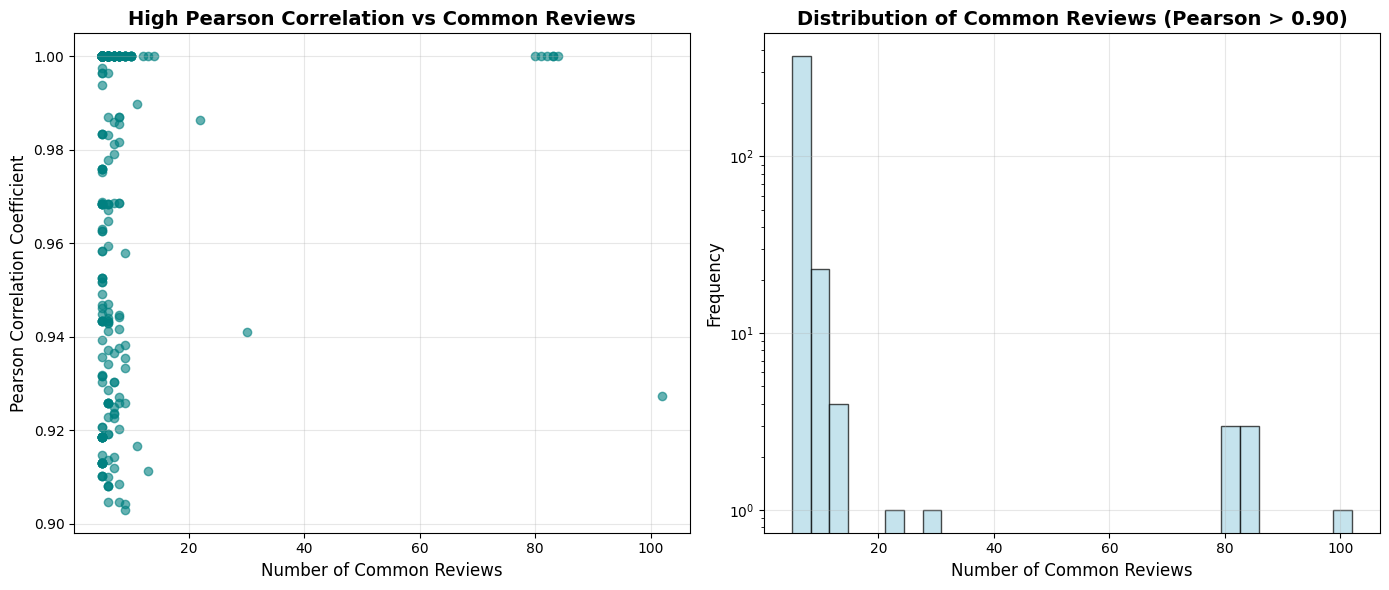

In [ ]:
# Focus on high positive correlations (e.g., Pearson > 0.99)
high_corr_edges = [(u, v, d) for u, v, d in user_projection.edges(data=True) if d['pearson'] is not None and d['pearson'] > 0.90]
print(f"Number of edges with Pearson correlation > 0.99: {len(high_corr_edges)}")

# Preparare the screen for two plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#  Scatterplot of high Pearson correlation vs number of common reviews
common_reviews = [d['weight'] for u, v, d in high_corr_edges]
pearson_values_high = [d['pearson'] for u, v, d in high_corr_edges]
axes[0].scatter(common_reviews, pearson_values_high, color='teal', alpha=0.6)
axes[0].set_xlabel('Number of Common Reviews', fontsize=12)
axes[0].set_ylabel('Pearson Correlation Coefficient', fontsize=12)
axes[0].set_title('High Pearson Correlation vs Common Reviews', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
# Histogram of number of common reviews for high Pearson correlations
axes[1].hist(common_reviews, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of Common Reviews', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Common Reviews (Pearson > 0.90)', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Community Detection

## Compute the Community Detection Algorithm

### Louvain

In [ ]:
#solo da caricamento colab
try:
    with open('Louvain_coms.pkl', 'rb') as f:
         Louvain_coms = pickle.load(f)
except FileNotFoundError:
    Louvain_coms = community_louvain.community_louvain.best_partition(user_projection, weight='weight')

In [ ]:
# Add the targeted community as a label of nodes
nx.set_node_attributes(user_projection, Louvain_coms, 'Louvain_community')

### Leiden

In [ ]:
try:
    with open('Leiden_coms.pkl', 'rb') as f:
        # Load the communities as a list of lists
        Leiden_coms = pickle.load(f)
except (FileNotFoundError, EOFError):
    Leiden_coms = leidenalg.find_partition(ig.Graph.from_networkx(user_projection), leidenalg.ModularityVertexPartition, weights='weight')

In [ ]:
# Add the community as node attribute
leiden_partition_dict = {}
for community_id, members in enumerate(Leiden_coms):
    for node in members:
        leiden_partition_dict[node] = community_id

nx.set_node_attributes(user_projection, leiden_partition_dict, 'Leiden_community')

### Infomap

In [ ]:
try:
    with open('Infomap_coms.pkl', 'rb') as f:
         Infomap_coms = pickle.load(f)
except FileNotFoundError:
  im = Infomap()
  for u, v, d in user_projection.edges(data=True):
      im.addLink(u, v, d['weight'])
  im.run()
  Infomap_coms = {node.node_id: node.moduleIndex() for node in im.nodes}

In [ ]:
# add the targeted community as a label of nodes
nx.set_node_attributes(user_projection, Infomap_coms, 'Infomap_community')

### Comparison

In [ ]:
# Comparison of the number of communities detected by each algorithm
num_louvain_coms = len(set(Louvain_coms.values()))
num_leiden_coms = len(Leiden_coms)
num_infomap_coms = len(set(Infomap_coms.values()))
print("\nCommunity Detection Results:")
print(f"  • Louvain detected {num_louvain_coms} communities.")
print(f"  • Leiden detected {num_leiden_coms} communities.")
print(f"  • Infomap detected {num_infomap_coms} communities.")


Community Detection Results:
  • Louvain detected 51970 communities.
  • Leiden detected 52031 communities.
  • Infomap detected 10001 communities.


### Metrics

In [ ]:
def get_metrics(community_obj_cdlib_format, graph):
    """
    Computes various community detection metrics for a given NodeClustering object.

    Args:
        community_obj_cdlib_format: A cdlib.classes.node_clustering.NodeClustering object.
        graph: The NetworkX graph object.

    Returns:
        dict: A dictionary of computed metrics.
    """
    return {
        "Modularity": evaluation.newman_girvan_modularity(graph, community_obj_cdlib_format).score,
        "Avg. Conductance": evaluation.conductance(graph, community_obj_cdlib_format).score,
        "Internal Density": evaluation.internal_edge_density(graph, community_obj_cdlib_format).score,
        "Expansion": evaluation.expansion(graph, community_obj_cdlib_format).score
    }

In [ ]:
# Convert Louvain_coms (dict: node -> community_id) to NodeClustering object
louvain_grouped_coms = defaultdict(list)
for node, com_id in Louvain_coms.items():
    louvain_grouped_coms[com_id].append(node)
louvain_node_clustering = NodeClustering(list(louvain_grouped_coms.values()), user_projection, method_name="Louvain")

# Convert Leiden_coms (igraph VertexClustering object) to NodeClustering object
# igraph.clustering.VertexClustering objects are iterable and yield lists of node IDs
leiden_node_clustering = NodeClustering(list(Leiden_coms), user_projection, method_name="Leiden")

# Convert Infomap_coms (dict: node -> community_id) to NodeClustering object
infomap_grouped_coms = defaultdict(list)
for node, com_id in Infomap_coms.items():
    infomap_grouped_coms[com_id].append(node)
infomap_node_clustering = NodeClustering(list(infomap_grouped_coms.values()), user_projection, method_name="Infomap")


In [ ]:
# Metrics computation
results = {
    "Louvain": get_metrics(louvain_node_clustering, user_projection),
    "Leiden": get_metrics(leiden_node_clustering, user_projection),
    "Infomap": get_metrics(infomap_node_clustering, user_projection),
}

In [ ]:
# Comparative table
df = pd.DataFrame(results).T
print("--- Comparative Table of Internal Metrics ---")
print(df)

--- Comparative Table of Internal Metrics ---
         Modularity  Avg. Conductance  Internal Density  Expansion
Louvain    0.747233          0.000452          0.184496   0.010492
Leiden    -0.001753          0.373605          0.000087  23.285576
Infomap    0.647083          0.003151          0.949259   0.048838


## Analysis of communities and Pearson correlation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import defaultdict

# --- LOUVAIN ANALYSIS ---
# Distribution of community sizes for Louvain (OPTIMIZED)
louvain_sizes = pd.Series(list(Louvain_coms.values())).value_counts()

# Compute average pearson correlation for the internal edges of each community detected by Louvain
# Group nodes by community in a single pass
community_members_louvain = defaultdict(list)
for node, com in Louvain_coms.items():
    community_members_louvain[com].append(node)

louvain_avg_pearson = {}
for com, members in community_members_louvain.items():
    # Create subgraph only once per community
    subgraph = user_projection.subgraph(members)

    # Extract pearson values directly
    pearson_values = [data['pearson'] for u, v, data in subgraph.edges(data=True)
                      if data.get('pearson') is not None and not math.isnan(data['pearson'])]

    if pearson_values:
        louvain_avg_pearson[com] = np.mean(pearson_values)
    else:
        louvain_avg_pearson[com] = float('nan')

# --- INFOMAP ANALYSIS (Added for Comparison) ---
# Distribution of community sizes for Infomap
infomap_sizes = pd.Series(list(Infomap_coms.values())).value_counts()

# Group nodes by community for Infomap
community_members_infomap = defaultdict(list)
for node, com in Infomap_coms.items():
    community_members_infomap[com].append(node)

infomap_avg_pearson = {}
for com, members in community_members_infomap.items():
    # Create subgraph for Infomap community
    subgraph = user_projection.subgraph(members)

    # Extract pearson values
    pearson_values = [data['pearson'] for u, v, data in subgraph.edges(data=True)
                      if data.get('pearson') is not None and not math.isnan(data['pearson'])]

    if pearson_values:
        infomap_avg_pearson[com] = np.mean(pearson_values)
    else:
        infomap_avg_pearson[com] = float('nan')

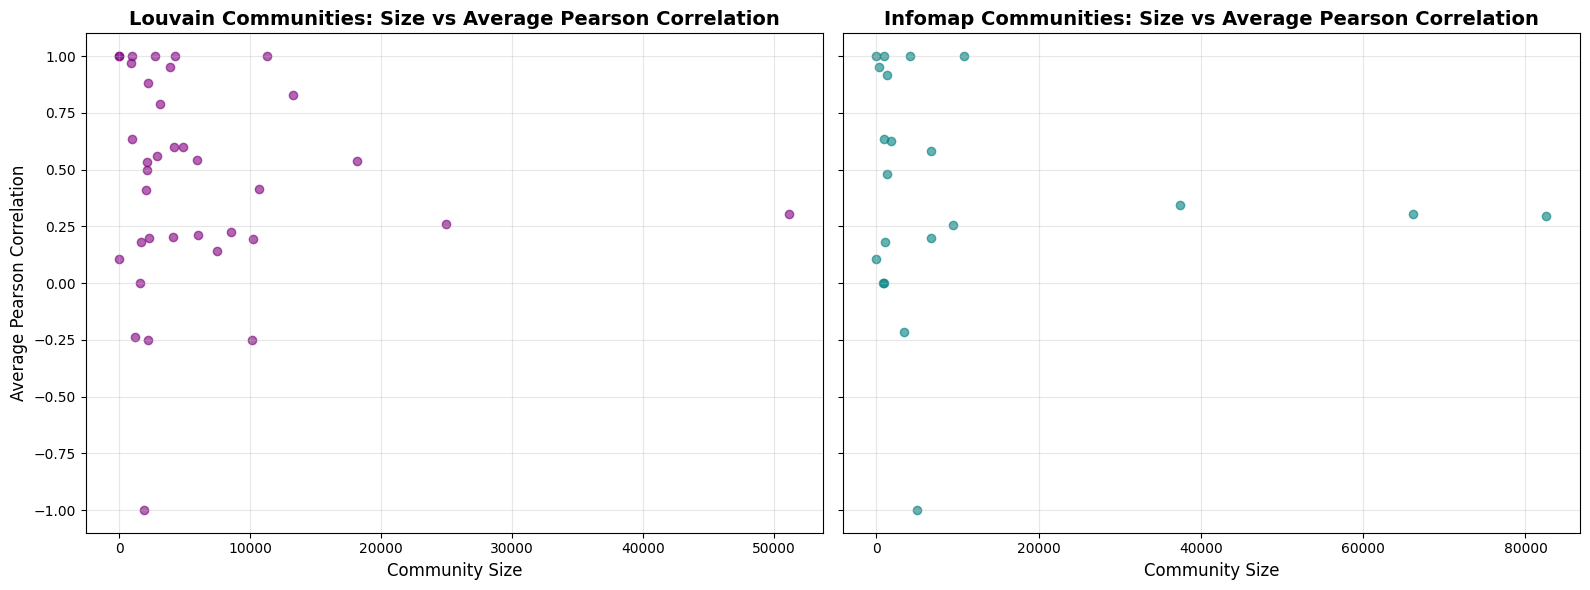

In [ ]:
# --- COMPARATIVE VISUALIZATION ---
# Scatter plot of community size vs average Pearson correlation
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for Louvain
axes[0].scatter(louvain_sizes.values, [louvain_avg_pearson[com] for com in louvain_sizes.index], color='purple', alpha=0.6)
axes[0].set_xlabel('Community Size', fontsize=12)
axes[0].set_ylabel('Average Pearson Correlation', fontsize=12)
axes[0].set_title('Louvain Communities: Size vs Average Pearson Correlation', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot for Infomap
axes[1].scatter(infomap_sizes.values, [infomap_avg_pearson[com] for com in infomap_sizes.index], color='teal', alpha=0.6)
axes[1].set_xlabel('Community Size', fontsize=12)
axes[1].set_title('Infomap Communities: Size vs Average Pearson Correlation', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

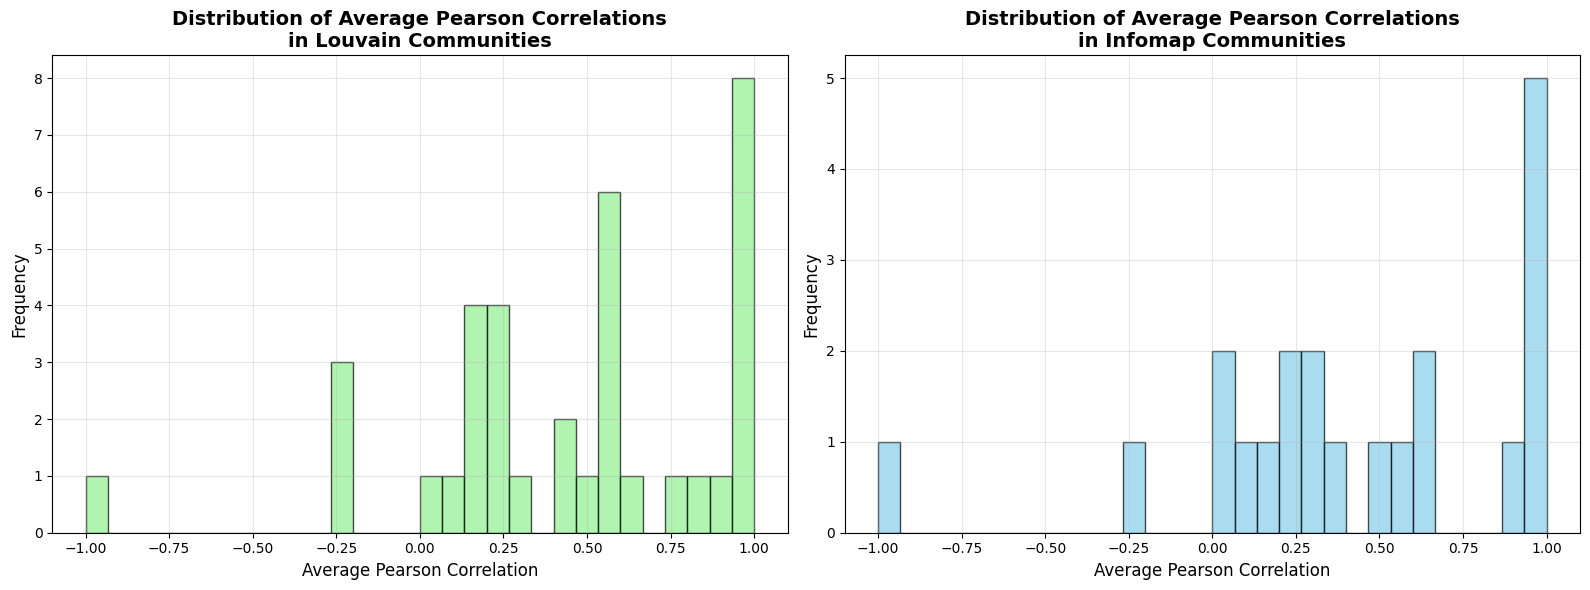

In [ ]:
import matplotlib.pyplot as plt
import math

# --- COMPARATIVE HISTOGRAM VISUALIZATION ---
# Prepare the figure for two side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# 1. Histogram of internal average Pearson correlations for Louvain communities
axes[0].hist([v for v in louvain_avg_pearson.values() if not math.isnan(v)],
             bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Average Pearson Correlation', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Average Pearson Correlations\nin Louvain Communities', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 2. Histogram of internal average Pearson correlations for Infomap communities
# Added for comparison with Infomap specific data
axes[1].hist([v for v in infomap_avg_pearson.values() if not math.isnan(v)],
             bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Average Pearson Correlation', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Average Pearson Correlations\nin Infomap Communities', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Filtering of communities

### By internal average Pearson coeffient

In [ ]:
pearson_threshold = 0.94

In [ ]:
# Compute internal average Pearson for Leiden communities
# Create igraph for mapping
ig_graph = ig.Graph.from_networkx(user_projection)
# Get node name mapping from igraph indices to original node IDs
node_mapping = {i: ig_graph.vs[i]['_nx_name'] for i in range(len(ig_graph.vs))}

leiden_avg_pearson = {}
for idx, com in enumerate(Leiden_coms):
    # Map igraph indices back to original node IDs
    members = [node_mapping[node_idx] for node_idx in com]
    subgraph = user_projection.subgraph(members)

    # Extract pearson values directly with NaN check
    pearson_values = [data['pearson'] for u, v, data in subgraph.edges(data=True)
                      if data.get('pearson') is not None and not math.isnan(data['pearson'])]

    if pearson_values:
        leiden_avg_pearson[idx] = np.mean(pearson_values)
    else:
        leiden_avg_pearson[idx] = float('nan')


# Compute internal average Pearson for Infomap communities (OPTIMIZED)
# Group nodes by community in a single pass
infomap_community_members = defaultdict(list)
for node, com in Infomap_coms.items():
    infomap_community_members[com].append(node)

infomap_avg_pearson = {}
for com, members in infomap_community_members.items():
    subgraph = user_projection.subgraph(members)

    # Extract pearson values directly with NaN check
    pearson_values = [data['pearson'] for u, v, data in subgraph.edges(data=True)
                      if data.get('pearson') is not None and not math.isnan(data['pearson'])]

    if pearson_values:
        infomap_avg_pearson[com] = np.mean(pearson_values)
    else:
        infomap_avg_pearson[com] = float('nan')

In [ ]:
# Filter coommunities with internal average Pearson correlation greater than a threshold for each algorithm
significant_louvain_coms = {com: avg_pearson for com, avg_pearson in louvain_avg_pearson.items() if not math.isnan(avg_pearson) and avg_pearson > pearson_threshold}
significant_leiden_coms = {com: avg_pearson for com, avg_pearson in leiden_avg_pearson.items() if not math.isnan(avg_pearson) and avg_pearson > pearson_threshold}
significant_infomap_coms = {com: avg_pearson for com, avg_pearson in infomap_avg_pearson.items() if not math.isnan(avg_pearson) and avg_pearson > pearson_threshold}
print(f"\nCommunities with average Pearson correlation > {pearson_threshold}:")
print(f"  • Louvain: {len(significant_louvain_coms)} communities")
print(f"  • Leiden: {len(significant_leiden_coms)} communities")
print(f"  • Infomap: {len(significant_infomap_coms)} communities")



Communities with average Pearson correlation > 0.94:
  • Louvain: 8 communities
  • Leiden: 9 communities
  • Infomap: 5 communities


### By size of communities

In [ ]:
min_size = 5

In [ ]:
# Filter communities with a threshold of minimum size and considering the pearson coefficient

# Filtered Louvain partition
large_louvain_coms = {com_id: size for com_id, size in louvain_sizes.items() if com_id in significant_louvain_coms and size >= min_size}

# Filtered Leiden partition
large_leiden_coms = {}
for idx, part in enumerate(Leiden_coms):
    if idx in significant_leiden_coms and len(part) >= min_size:
        large_leiden_coms[idx] = len(part)

# Filtered Infomap partition
large_infomap_coms = {}
for com_id in set(Infomap_coms.values()):
    # Only consider communities that passed the Pearson filter
    if com_id in significant_infomap_coms:
        size = list(Infomap_coms.values()).count(com_id)
        if size >= min_size:
            large_infomap_coms[com_id] = size

print(f"\nCommunities with at least {min_size} members AND average Pearson correlation > {pearson_threshold}:")
print(f"  • Louvain: {len(large_louvain_coms)} communities")
print(f"  • Leiden: {len(large_leiden_coms)} communities")
print(f"  • Infomap: {len(large_infomap_coms)} communities")


Communities with at least 5 members AND average Pearson correlation > 0.94:
  • Louvain: 7 communities
  • Leiden: 8 communities
  • Infomap: 4 communities


## Consensus Communities

### Function that fuse the partitions (Co-association Matrix)

In [ ]:
from scipy.sparse import lil_matrix
from sklearn.cluster import AgglomerativeClustering

def fuse_partitions_agglomerative_union(partitions_data, distance_threshold=0.5, linkage='complete'):
    """
    Fuses multiple community detection partitions using the
    Co-association Matrix method, handling missing nodes through UNION.
    Memory-optimized version using sparse matrices.

    Args:
        partitions_data (list of dict): A list of dictionaries, where each dictionary
                                        maps node (key) to its community label (value).
        distance_threshold (float): Distance threshold for hierarchical clustering
                                    (Default 0.5). Lower values = more communities.
        linkage (str): Linkage method ('complete', 'average', 'single').

    Returns:
        tuple: (dict: Final consensus partition as node->community dictionary,
                None: placeholder for compatibility)
    """
    if not partitions_data:
        raise ValueError("The partition list cannot be empty.")

    # 1. IDENTIFICATION OF NODES IN UNION
    all_nodes = set()
    for partition in partitions_data:
        all_nodes.update(partition.keys())

    ordered_nodes = sorted(list(all_nodes))
    num_nodes = len(ordered_nodes)
    num_partitions = len(partitions_data)

    if num_nodes == 0:
        print("WARNING: No nodes found in any partition.")
        return {}, None

    print(f"Total nodes analyzed (Union): {num_nodes}")
    print(f"Input partitions: {num_partitions}")

    # 2. EXTRACTION AND ALIGNMENT OF LABELS
    aligned_partitions = []
    for idx, partition in enumerate(partitions_data):
        aligned_labels = []
        max_label = max(partition.values()) if partition else -1
        missing_label_base = max_label + 1000 * (idx + 1)
        missing_counter = 0

        for node in ordered_nodes:
            if node in partition:
                aligned_labels.append(partition[node])
            else:
                aligned_labels.append(missing_label_base + missing_counter)
                missing_counter += 1

        aligned_partitions.append(np.array(aligned_labels))

        present = sum(1 for node in ordered_nodes if node in partition)
        missing = num_nodes - present
        print(f"  Partition {idx+1}: {present} nodes present, {missing} nodes missing")

    # --- PHASE 3: Co-association calculation with sparse matrix ---
    print("Calculating co-association matrix (optimized)...")

    # Use sparse matrix to save memory
    C_sparse = lil_matrix((num_nodes, num_nodes), dtype=np.float32)

    # Calculate co-association only for pairs of nodes in the same community
    for P in aligned_partitions:
        # Group nodes by community
        comm_to_nodes = defaultdict(list)
        for i, label in enumerate(P):
            comm_to_nodes[label].append(i)

        # Update only pairs in the same community
        for nodes_in_comm in comm_to_nodes.values():
            if len(nodes_in_comm) > 1:
                for i in nodes_in_comm:
                    for j in nodes_in_comm:
                        if i <= j:  # Symmetric matrix
                            C_sparse[i, j] += 1

    # Normalize and convert to dense matrix (required for AgglomerativeClustering)
    print("Converting to dense matrix and normalizing...")
    C_dense = C_sparse.toarray()

    # Make symmetric
    C_dense = C_dense + C_dense.T - np.diag(np.diag(C_dense))

    # Normalize
    C_norm = C_dense / num_partitions

    # Free memory
    del C_sparse, C_dense

    # --- PHASE 4: Re-clustering ---
    print("Agglomerative hierarchical clustering...")
    D = 1 - C_norm

    agglo = AgglomerativeClustering(
        n_clusters=None,
        distance_threshold=distance_threshold,
        linkage=linkage,
        metric='precomputed'
    )

    consensus_labels = agglo.fit_predict(D)

    consensus_partition = {node: int(label) for node, label in zip(ordered_nodes, consensus_labels)}

    return consensus_partition, None

### Preparation of Filtered Partitions

In [ ]:
# Prepare filtered partitions combining both filters (size and pearson)
# Filtered Louvain partition
partition_louvain_filtered = {}
for node, com in Louvain_coms.items():
    if com in significant_louvain_coms and com in large_louvain_coms:
        partition_louvain_filtered[node] = com

# Filtered Leiden partition
partition_leiden_filtered = {}
for idx, part in enumerate(Leiden_coms):
    if idx in significant_leiden_coms and idx in large_leiden_coms:
        # Map igraph indices back to original node IDs
        for node_idx in part:
            original_node = node_mapping[node_idx]
            partition_leiden_filtered[original_node] = idx

# Filtered Infomap partition
partition_infomap_filtered = {}
for node, com in Infomap_coms.items():
    if com in significant_infomap_coms and com in large_infomap_coms:
        partition_infomap_filtered[node] = com

print(f"\nFiltered partitions (Pearson > {pearson_threshold} AND Size >= {min_size}):")
print(f"  • Louvain: {len(set(partition_louvain_filtered.values()))} communities, {len(partition_louvain_filtered)} nodes")
print(f"  • Leiden: {len(set(partition_leiden_filtered.values()))} communities, {len(partition_leiden_filtered)} nodes")
print(f"  • Infomap: {len(set(partition_infomap_filtered.values()))} communities, {len(partition_infomap_filtered)} nodes")


Filtered partitions (Pearson > 0.94 AND Size >= 5):
  • Louvain: 7 communities, 24236 nodes
  • Leiden: 8 communities, 26041 nodes
  • Infomap: 4 communities, 16244 nodes


### Application of Fusion

In [ ]:
  # Apply the function to the three filtered partitions
print("\n" + "="*70)
print("Starting partition fusion...")
print("="*70)
partition_consensus, _ = fuse_partitions_agglomerative_union(
    [partition_louvain_filtered,
    partition_infomap_filtered],
    distance_threshold=0.5,
    linkage='average'
)


Starting partition fusion...
Total nodes analyzed (Union): 29433
Input partitions: 2
  Partition 1: 24236 nodes present, 5197 nodes missing
  Partition 2: 16244 nodes present, 13189 nodes missing
Calculating co-association matrix (optimized)...
Converting to dense matrix and normalizing...
Agglomerative hierarchical clustering...


#### adjustments

In [ ]:

# Filtering the consensus partition with Pearson and size criteria
# First, compute community sizes in the consensus partition
from collections import Counter
consensus_sizes = Counter(partition_consensus.values())
# Identify significant communities based on size
significant_consensus_coms = {com for com, size in consensus_sizes.items() if size >= min_size}
# Filter the consensus partition
partition_consensus = {node: com for node, com in partition_consensus.items() if com in significant_consensus_coms}
# Second, compute internal average Pearson for consensus communities
consensus_avg_pearson = {}
for com in significant_consensus_coms:
    members = [node for node, c in partition_consensus.items() if c == com]
    subgraph = user_projection.subgraph(members)

    # Extract pearson values directly with NaN check
    pearson_values = [data['pearson'] for u, v, data in subgraph.edges(data=True)
                      if data.get('pearson') is not None and not math.isnan(data['pearson'])]

    if pearson_values:
        consensus_avg_pearson[com] = np.mean(pearson_values)
    else:
        consensus_avg_pearson[com] = float('nan')
# Final filtering based on Pearson threshold
final_significant_consensus_coms = {com for com, avg_pearson in consensus_avg_pearson.items() if not math.isnan(avg_pearson) and avg_pearson > pearson_threshold}
partition_consensus = {node: com for node, com in partition_consensus.items() if com in final_significant_consensus_coms}

# Update graph attributes
nx.set_node_attributes(user_projection, partition_consensus, "community_consensus")

In [ ]:
print(f"\nFinal comparison:")
print(f"  • Filtered Louvain: {len(set(partition_louvain_filtered.values()))} communities, {len(partition_louvain_filtered)} nodes")
print(f"  • Filtered Leiden: {len(set(partition_leiden_filtered.values()))} communities, {len(partition_leiden_filtered)} nodes")
print(f"  • Filtered Infomap: {len(set(partition_infomap_filtered.values()))} communities, {len(partition_infomap_filtered)} nodes")
print(f"  • Consensus: {len(set(partition_consensus.values()))} communities, {len(partition_consensus)} nodes")
print("="*70)


Final comparison:
  • Filtered Louvain: 7 communities, 24236 nodes
  • Filtered Leiden: 8 communities, 26041 nodes
  • Filtered Infomap: 4 communities, 16244 nodes
  • Consensus: 4 communities, 10750 nodes


## Show the Consensus Communities

In [ ]:
# Compute metrics for Consensus Communities
consensus_metrics = {}

for com in set(partition_consensus.values()):
    members = [node for node, c in partition_consensus.items() if c == com]
    subgraph = user_projection.subgraph(members)

    # Compute the size of the community
    size = len(members)

    # Compute the internal edges
    internal_edges = subgraph.number_of_edges()

    # Compute the internal Pearson average
    pearson_values = [d['pearson'] for u, v, d in subgraph.edges(data=True) if d['pearson'] is not None and not math.isnan(d['pearson'])]
    avg_pearson = np.mean(pearson_values) if pearson_values else float('nan')

    # Compute the internal Pearson std
    std_pearson = np.std(pearson_values) if pearson_values else float('nan')

    # Compute the internal density
    density = nx.density(subgraph) if size > 1 else 0.0

    # Compute the sum of the weights of internal edges
    sum_weights = sum(d.get('weight', 1) for u, v, d in subgraph.edges(data=True))

    consensus_metrics[com] = {
        'size': size,
        'internal_edges': internal_edges,
        'avg_pearson': avg_pearson,
        'std_pearson': std_pearson,
        'density': density,
        'sum_weights': sum_weights
    }

# Show a table with these metrics
metrics_df = pd.DataFrame(consensus_metrics).T
metrics_df = metrics_df.sort_values('size', ascending=False)

print("\n" + "="*90)
print("Consensus Communities Metrics".center(90))
print("="*90)
print(f"\n{'Community':<12} {'Size':<8} {'Edges':<8} {'Avg Pearson':<15} {'Std Pearson':<15} {'Density':<10} {'Sum Weights':<12}")
print("-"*90)

for com, metrics in metrics_df.iterrows():
    print(f"{com:<12} {int(metrics['size']):<8} {int(metrics['internal_edges']):<8} "
          f"{metrics['avg_pearson']:<15.4f} {metrics['std_pearson']:<15.4f} {metrics['density']:<10.6f} {metrics['sum_weights']:<12.4f}")

print("-"*90)
print(f"Total communities: {len(consensus_metrics)}")
print(f"Total nodes in communities: {sum(m['size'] for m in consensus_metrics.values())}")
print("="*90)


                              Consensus Communities Metrics                               

Community    Size     Edges    Avg Pearson     Std Pearson     Density    Sum Weights 
------------------------------------------------------------------------------------------
0            9151     148199   1.0000          0.0000          0.003540   149603.0000 
2            715      8526     1.0000          0.0000          0.033402   8595.0000   
5            575      9309     1.0000          0.0000          0.056410   9454.0000   
1            309      1988     0.9517          0.0000          0.041777   2017.0000   
------------------------------------------------------------------------------------------
Total communities: 4
Total nodes in communities: 10750


In [ ]:
# Convert partition_consensus (dict: node -> community_id) to NodeClustering object
consensus_grouped_coms = defaultdict(list)
for node, com_id in partition_consensus.items():
    consensus_grouped_coms[com_id].append(node)
consensus_node_clustering = NodeClustering(list(consensus_grouped_coms.values()), user_projection, method_name="Consensus")

In [ ]:
results['Consensus'] = get_metrics(consensus_node_clustering, user_projection)

In [ ]:
# Comparative table
df = pd.DataFrame(results).T
print("--- Comparative Table of Internal Metrics ---")
print(df)

--- Comparative Table of Internal Metrics ---
           Modularity  Avg. Conductance  Internal Density  Expansion
Louvain      0.747233          0.000452          0.184496   0.010492
Leiden      -0.001753          0.373605          0.000087  23.285576
Infomap      0.647083          0.003151          0.949259   0.048838
Consensus    0.004044          0.159618          0.033782   4.415530


In [ ]:
sbm_stats = evaluation.erdos_renyi_modularity(user_projection, consensus_node_clustering)
print(f"\n Estimate if SNR by using SBM logic: {sbm_stats.score:.4f}")


 Estimate if SNR by using SBM logic: 0.0245


# Burstiness Analysis


In [ ]:
df_target = df_2006.copy()

## Burstiness based on amount of time between two events

In [ ]:
import pandas as pd
import numpy as np

def analyze_and_rank_suspicious(df_target):
    """
    Calculates burstiness based on inter-arrival times (tau) according to Ch. 10,
    identifies suspicious products and returns a ranking.

    :param df_target: DataFrame with columns 'product_id', 'time', 'review'.
    :return: Filtered DataFrame sorted by descending burstiness.
    """

    # --- 1. Inter-event Time Calculation (Tau) ---
    # Sort to follow the correct temporal trajectory
    df = df_target.sort_values(by=['product_id', 'time']).copy()

    # Calculate time difference between a review and the previous one
    df['prev_time'] = df.groupby('product_id')['time'].shift(1)

    # Tau in hours. Use seconds / 3600 to get a manageable float
    df['tau'] = (df['time'] - df['prev_time']).dt.total_seconds() / 3600.0

    # Remove the first review of each group (tau is NaN)
    df_intervals = df.dropna(subset=['tau'])

    # --- 2. Statistics per Product (Aggregation) ---
    stats = df_intervals.groupby('product_id').agg(
        review_count=('tau', 'count'),          # Number of intervals (N reviews - 1)
        mu_tau=('tau', 'mean'),                 # Mean waiting time
        sigma_tau=('tau', 'std'),               # Standard deviation of waiting times
        mean_rating=('review', 'mean'),         # Average rating
        std_rating=('review', 'std')            # Rating standard deviation (polarization)
    ).reset_index()

    stats = stats.fillna(0) # Handle edge cases

    # --- 3. Burstiness Coefficient (B) Calculation ---
    # Formula: B = (sigma - mu) / (sigma + mu)
    # Range: -1 (regular), 0 (random/Poisson), +1 (maximum burstiness)
    def calculate_burst_coefficient(row):
        denom = row['sigma_tau'] + row['mu_tau']
        if denom == 0: return 0
        return (row['sigma_tau'] - row['mu_tau']) / denom

    stats['burstiness_coef'] = stats.apply(calculate_burst_coefficient, axis=1)

    # --- 4. "Suspicious" Logic ---
    # We define as suspicious those who have:
    # 1. High Burstiness (> 0.1): Indicates non-random "burst-like" dynamics
    # 2. Rating Polarization: Very high or very low ratings with low variance
    # 3. Minimum Volume: At least 3 reviews for statistical significance

    is_bursty = stats['burstiness_coef'] > 0.1


    has_volume = stats['review_count'] >= 3

    stats['is_suspicious'] = is_bursty & has_volume

    # --- 5. Filtering and Ranking (Requested part) ---

    # Keep only suspicious items
    suspicious_df = stats[stats['is_suspicious']].copy()

    # Sort by descending Burstiness (the most "explosive" at the top)
    suspicious_df = suspicious_df.sort_values(by='burstiness_coef', ascending=False)

    # Select and rename columns for the final presentation
    output_cols = [
        'product_id',
        'burstiness_coef',
        'review_count',
        'mean_rating',
        'mu_tau' # Useful to see how many hours pass on average between reviews
    ]

    return suspicious_df[output_cols]

Now the objective is to take the results on Burstiness analysis on suspicious products and, integrating with the results on suspicious users (communities), verify if there exists correspondence between the two

In [ ]:
from collections import defaultdict
import pandas as pd

def get_all_products_by_communities(partition_communities, G_bipartite):
    """
    Extracts all products reviewed by members of all communities.

    Args:
        partition_communities: Dictionary node -> community (e.g., partition_consensus)
        G_bipartite: Bipartite graph (G) with users and products

    Returns:
        df_all: DataFrame with product_id, user_id, community_id for each review
    """
    # List to store all product-user-community combinations
    all_data = []

    # Get all unique communities
    unique_communities = set(partition_communities.values())

    for community_id in sorted(unique_communities):
        # Find all users belonging to the community
        community_users = [user for user, comm in partition_communities.items()
                          if comm == community_id]

        users_found = 0
        users_missing = 0
        products_set = set()

        for user in community_users:
            if user in G_bipartite:
                users_found += 1
                # Get all products reviewed by this user
                user_products = list(G_bipartite[user].keys())
                products_set.update(user_products)

                for product in user_products:
                    all_data.append({
                        'product_id': product,
                        'user_id': user,
                        'community_id': community_id
                    })
            else:
                users_missing += 1

    # Create final DataFrame
    df_all = pd.DataFrame(all_data)
    return df_all

In [ ]:
# Apply the function to extract all products reviewed by all communities
df_all_communities = get_all_products_by_communities(partition_consensus, G)

# Merge df_all_communities with df_2006 to obtain temporal and review information
df_communities_full = df_all_communities.merge(
    df_2006[['user_id', 'product_id', 'time', 'review']],
    on=['user_id', 'product_id'],
    how='left'
)

In [ ]:
all_suspicious_products = []

# Get all unique communities
unique_communities = sorted(df_communities_full['community_id'].unique())

for comm_id in unique_communities:
    # Filter reviews for the specific community
    df_community = df_communities_full[df_communities_full['community_id'] == comm_id].copy()

    # Calculate local burstiness (for this specific community)
    if len(df_community) > 0:
        suspicious_local = analyze_and_rank_suspicious(df_community)

        if len(suspicious_local) > 0:
            # Add community_id column
            suspicious_local['community_id'] = comm_id

            # Rename columns to distinguish local statistics
            suspicious_local = suspicious_local.rename(columns={
                'burstiness_coef': 'burstiness_local',
                'review_count': 'reviews_local',
                'mean_rating': 'mean_rating_local',
                'mu_tau': 'mu_tau_local'
            })

            all_suspicious_products.append(suspicious_local)

# Combine all results
if all_suspicious_products:
    df_suspicious_combined = pd.concat(all_suspicious_products, ignore_index=True)

    # Calculate GLOBAL statistics for each product (on the entire df_2006)
    global_stats = []

    for product_id in df_suspicious_combined['product_id'].unique():
        # Filter global reviews for the product
        df_product_global = df_2006[df_2006['product_id'] == product_id].copy()

        if len(df_product_global) > 0:
            suspicious_global = analyze_and_rank_suspicious(df_product_global)

            if len(suspicious_global) > 0:
                global_stats.append({
                    'product_id': product_id,
                    'burstiness_global': suspicious_global.iloc[0]['burstiness_coef'],
                    'reviews_global': suspicious_global.iloc[0]['review_count'],
                    'mean_rating_global': suspicious_global.iloc[0]['mean_rating'],
                    'mu_tau_global': suspicious_global.iloc[0]['mu_tau']
                })
            else:
                # Product not suspicious at a global level
                global_stats.append({
                    'product_id': product_id,
                    'burstiness_global': np.nan,
                    'reviews_global': len(df_product_global),
                    'mean_rating_global': df_product_global['review'].mean(),
                    'mu_tau_global': np.nan
                })

    df_global_stats = pd.DataFrame(global_stats)

    # Merge local and global statistics
    df_final = df_suspicious_combined.merge(df_global_stats, on='product_id', how='left')

    # Sort by descending local burstiness
    df_final = df_final.sort_values('burstiness_local', ascending=False).reset_index(drop=True)

    # Reorder columns for readability
    columns_order = [
        'product_id',
        'community_id',
        'burstiness_local',
        'burstiness_global',
        'reviews_local',
        'reviews_global',
        'mean_rating_local',
        'mean_rating_global',
        'mu_tau_local',
        'mu_tau_global'
    ]

    df_final = df_final[columns_order]

    # Print results
    print(f"\n{'=' * 80}")
    print("COMPLETE SUSPICIOUS PRODUCTS TABLE".center(80))
    print(f"{'=' * 80}")
    print(f"\nTotal rows (product x community): {len(df_final)}")
    print(f"Unique suspicious products: {df_final['product_id'].nunique()}")
    print(f"Communities with suspicious products: {df_final['community_id'].nunique()}")

    print(f"\n{'-' * 80}")
    print("COLUMN LEGEND:")
    print(f"{'-' * 80}")
    print("• burstiness_local: Burstiness coefficient calculated for the specific community")
    print("• burstiness_global: Burstiness coefficient calculated on all 2006 reviews")
    print("• reviews_local: Number of reviews within the community")
    print("• reviews_global: Total number of reviews in 2006")
    print("• mean_rating_local/global: Local vs global average rating")
    print("• mu_tau_local/global: Average time (hours) between successive reviews")

    print(f"\n{'-' * 80}")
    print("COMPLETE TABLE:")
    print(f"{'-' * 80}\n")

    # Print complete table with formatting
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.float_format', '{:.4f}'.format)

    print(df_final.to_string(index=False))

    print(f"\n🏘️ Distribution by community:")
    comm_counts = df_final['community_id'].value_counts().sort_index()
    for comm_id, count in comm_counts.items():
        print(f"  • Community {comm_id}: {count} suspicious products")

    # Save DataFrame for later use
    df_suspicious_final = df_final.copy()

else:
    df_suspicious_final = pd.DataFrame()


                       COMPLETE SUSPICIOUS PRODUCTS TABLE                       

Total rows (product x community): 146
Unique suspicious products: 146
Communities with suspicious products: 4

--------------------------------------------------------------------------------
COLUMN LEGEND:
--------------------------------------------------------------------------------
• burstiness_local: Burstiness coefficient calculated for the specific community
• burstiness_global: Burstiness coefficient calculated on all 2006 reviews
• reviews_local: Number of reviews within the community
• reviews_global: Total number of reviews in 2006
• mean_rating_local/global: Local vs global average rating
• mu_tau_local/global: Average time (hours) between successive reviews

--------------------------------------------------------------------------------
COMPLETE TABLE:
--------------------------------------------------------------------------------

 product_id  community_id  burstiness_local  burstiness_g

## Burstiness analysis with timestamps taking also into account mean rating before and during the suspicious action

### Function creation

In [ ]:
df_sus=df_final["product_id"]
df_sus

# Pre-calculate prior mean rating using the ENTIRE dataset (all years)
df_all_sorted = df.sort_values(by=['product_id', 'time']).copy()
df_all_sorted['prior_mean_rating'] = df_all_sorted.groupby('product_id')['review'].transform(
    lambda x: x.shift(1).expanding().mean()
)
df_all_sorted['prior_mean_rating'] = df_all_sorted['prior_mean_rating'].fillna(3.0)

# Now filter for 2006 AND suspicious products, keeping the calculated prior_mean_rating
df_products_sus = df_all_sorted[
    (df_all_sorted['year'] == 2006) & 
    (df_all_sorted['product_id'].isin(df_sus))
][['user_id', 'product_id', 'review', 'time', 'prior_mean_rating']].copy()

In [ ]:
import pandas as pd
import numpy as np

def analyze_burstiness_with_baseline(df_target, delta_time_str, min_rating_difference=1.0):
    """
    Analyzes burstiness, polarization, and deviation from the historical average (baseline)
    to identify suspicious coalitions.

    :param df_target: DataFrame containing reviews (must have 'product_id', 'review', 'time', 'prior_mean_rating').
    :param delta_time_str: String for the time interval (e.g., '1D', '7D').
    :param min_rating_difference: Minimum required difference between the burst mean and the prior mean.
    :return: DataFrame with aggregated statistics, including coalition identification.
    """

    # 1. The prior_mean_rating has already been calculated on the complete dataset and passed in the DataFrame

    # Sort data by product and time: ESSENTIAL for cumulative calculations.
    df_sorted = df_target.sort_values(by=['product_id', 'time']).copy()

    # 2. Grouping by Product and Time Window

    # Aggregate as before, but add the mean of 'prior_mean_rating' as the baseline.
    burst_analysis = df_sorted.groupby('product_id').resample(delta_time_str, on='time').agg(
        total_reviews=('review', 'count'),
        mean_rating=('review', 'mean'),
        std_rating=('review', 'std'),
        # The baseline for the window is the mean of the prior_mean_rating of reviews in that burst.
        baseline_prior_mean=('prior_mean_rating', 'first')
    ).reset_index()

    burst_analysis['std_rating'] = burst_analysis['std_rating'].fillna(0)

    # Remove periods without reviews
    burst_analysis = burst_analysis[burst_analysis['total_reviews'] > 0]

    # Calculate the maximum number of reviews in a single period (for the burst metric)
    max_reviews_per_product = burst_analysis.groupby('product_id')['total_reviews'].max().reset_index()
    max_reviews_per_product.columns = ['product_id', 'max_product_reviews']
    burst_analysis = pd.merge(burst_analysis, max_reviews_per_product, on='product_id', how='left')

    # 3. Coalition Metrics (Updated)

    # A. Burst Metric: (As defined before: >= 3 reviews AND >= 10% of historical max)
    burst_analysis['is_burst'] = (
        (burst_analysis['total_reviews'] >= 3) &
        (burst_analysis['total_reviews'] / burst_analysis['max_product_reviews'] >= 0.10)
    )

    # B. Polarization Metric: (Low standard deviation AND extreme mean)
    burst_analysis['is_polarized'] = (
        (burst_analysis['std_rating'] < 0.8) &
        (
            (burst_analysis['mean_rating'] <= 1.5) | # Can be adjusted to 2.0 and 4.0
            (burst_analysis['mean_rating'] >= 4.5)
        )
    )

    # C. Deviation from Baseline Metric (NEW CONDITION)

    # Calculate the absolute difference between the burst mean and the previous baseline
    burst_analysis['rating_diff_from_baseline'] = abs(
        burst_analysis['mean_rating'] - burst_analysis['baseline_prior_mean']
    )

    # Condition: the difference must be at least min_rating_difference (e.g., 1.0)
    burst_analysis['is_drastically_different'] = (
        burst_analysis['rating_diff_from_baseline'] >= min_rating_difference
    )

    # 4. Identification of Suspicious Coalitions (Combined)
    burst_analysis['is_suspicious_coalition'] = (
        burst_analysis['is_burst'] &
        burst_analysis['is_polarized'] &
        burst_analysis['is_drastically_different']
    )

    return burst_analysis

### Time Analysis

Over all the dataset, the timestamps exist only at 22.00 or 23.00, so it makes no sense to run the function for timespans of length smaller than 24h

In [ ]:
# Daily Analysis
daily_analysis = analyze_burstiness_with_baseline(df_products_sus, '1D',min_rating_difference=1)

# SuspiciousResults
suspicious_daily = daily_analysis[daily_analysis['is_suspicious_coalition'] == True].sort_values(
    by='total_reviews', ascending=False
)

print(f"Suspicious Results - 1 Day \n")
print(suspicious_daily)

Suspicious Results - 1 Day 

     product_id       time  total_reviews  mean_rating  std_rating  \
804       53213 2006-04-26              9       4.7778      0.6667   
180       10710 2006-01-16              4       5.0000      0.0000   
177       10710 2006-01-11              3       5.0000      0.0000   
185       10710 2006-01-22              3       5.0000      0.0000   
207       10710 2006-02-19              3       5.0000      0.0000   
192       10710 2006-02-01              3       5.0000      0.0000   
548       40395 2006-01-09              3       5.0000      0.0000   
700       53184 2006-01-04              3       5.0000      0.0000   
728       53184 2006-02-24              3       5.0000      0.0000   
917       92234 2006-03-17              3       4.6667      0.5774   

     baseline_prior_mean  max_product_reviews  is_burst  is_polarized  \
804               3.6981                    9      True          True   
180               3.5217                    5      Tru

In [ ]:
# 2 days analysis
daily2_analysis = analyze_burstiness_with_baseline(df_products_sus, '2D',min_rating_difference=1)

# SuspiciousResults
suspicious_daily2 = daily2_analysis[daily2_analysis['is_suspicious_coalition'] == True].sort_values(
    by='total_reviews', ascending=False
)

print(f"Suspicious Results - 2 Days\n")
print(suspicious_daily2)

Suspicious Results - 2 Days

      product_id       time  total_reviews  mean_rating  std_rating  \
139        10710 2006-01-15              5       5.0000      0.0000   
156        10710 2006-02-18              5       5.0000      0.0000   
722        92234 2006-03-17              5       4.8000      0.4472   
1096      266549 2006-04-23              5       4.8000      0.4472   
242        13403 2006-01-02              4       5.0000      0.0000   
142        10710 2006-01-21              3       5.0000      0.0000   
137        10710 2006-01-11              3       5.0000      0.0000   
82         10015 2006-01-02              3       5.0000      0.0000   
214        13338 2006-01-03              3       5.0000      0.0000   
428        40395 2006-01-09              3       5.0000      0.0000   
498        46734 2006-01-09              3       4.6667      0.5774   
570        53184 2006-02-22              3       5.0000      0.0000   
179        10711 2006-01-10              3      

In [ ]:
# Weekly Analysis
weekly_analysis = analyze_burstiness_with_baseline(df_products_sus, '7D',min_rating_difference=1)


# Suspicious results
suspicious_weekly = weekly_analysis[weekly_analysis['is_suspicious_coalition'] == True].sort_values(
    by='total_reviews', ascending=False
)

print(f"Suspicious Results - 1 Week\n")
print(suspicious_weekly)

Suspicious Results - 1 Week

      product_id       time  total_reviews  mean_rating  std_rating  \
126        13403 2006-01-02             10       4.8000      0.4216   
294        53184 2006-01-01             10       4.7000      0.6749   
70         10710 2006-01-15              9       5.0000      0.0000   
630       266549 2006-04-22              7       4.7143      0.4880   
223        40395 2006-01-09              5       4.8000      0.4472   
1069      842070 2006-01-08              5       5.0000      0.0000   
392        93864 2006-01-25              4       5.0000      0.0000   
21          5118 2006-01-24              4       5.0000      0.0000   
163        25347 2006-01-09              4       5.0000      0.0000   
961       677766 2006-02-22              4       4.7500      0.5000   
1049      822818 2006-03-23              4       4.7500      0.5000   
1107      901745 2006-02-14              4       5.0000      0.0000   
1062      834149 2006-01-08              4      

# More Deeper Analysis based on Weight - Pearson Relationship in the Edges

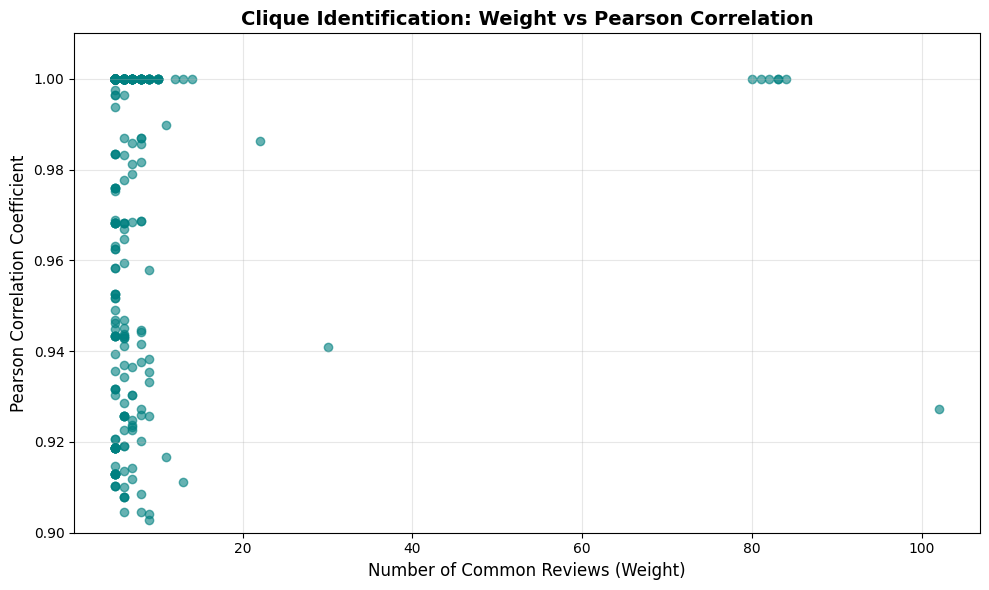

In [ ]:
# --- SCATTER PLOT: PEARSON VS WEIGHT ---

# Extract weights (number of common reviews) and pearson values from high correlation edges
# Assuming high_corr_edges is a list of tuples (u, v, data_dict)
common_reviews = [d['weight'] for u, v, d in high_corr_edges]
pearson_values_high = [d['pearson'] for u, v, d in high_corr_edges]

# Create the figure
plt.figure(figsize=(10, 6))

# Scatter plot to visualize the relationship
plt.scatter(common_reviews, pearson_values_high, color='teal', alpha=0.6)

# Graph styling
plt.xlabel('Number of Common Reviews (Weight)', fontsize=12)
plt.ylabel('Pearson Correlation Coefficient', fontsize=12)
plt.title('Clique Identification: Weight vs Pearson Correlation', fontsize=14, fontweight='bold')

# Setting limits to better highlight the top-right corner if necessary
plt.ylim(0.9, 1.01)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

From the scatterplot, we focus on edges with Pearson=1.0 and high weight.
We expect to find 6 specific edges connecting the same 4 users.

In [ ]:
from collections import Counter

# 1. Identify edges with maximum correlation and significant shared history to isolate the clique
pair_data = []
suspect_candidates = Counter()

for u, v, d in user_projection.edges(data=True):
    # Filter for perfect correlation and high shared product volume (>50)
    if d.get('pearson') == 1.0 and d.get('weight') > 50:
        pair_data.append({
            'user_A': u,
            'user_B': v,
            'weight': d.get('weight'),
            'pearson': d.get('pearson')
        })
        suspect_candidates.update([u, v])

# 2. Extract the specific group of users involved in these high-confidence edges
# We expect exactly 4 users forming a clique (6 edges)
target_suspects = [user for user, count in suspect_candidates.items() if count > 1]
target_suspects_set = set(target_suspects)

print(f"--- PHASE 1: CLIQUE IDENTIFICATION ---")
print(f"Number of high-confidence edges found: {len(pair_data)}")
print(f"Identified Suspect Group IDs: {target_suspects}")

--- PHASE 1: CLIQUE IDENTIFICATION ---
Number of high-confidence edges found: 6
Identified Suspect Group IDs: [np.int64(5876), 62654, 6515, 56207]


Investigate these 4 users to find they reviewed 79 products in common.

In [ ]:
# 3. Find the intersection of products reviewed by ALL 4 suspects
product_sets = []
for uid in target_suspects:
    products = set(df_2006[df_2006['user_id'].astype(int) == int(uid)]['product_id'])
    product_sets.append(products)

# Intersection operation: only keep products present in every suspect's history
common_products = set.intersection(*product_sets)

print(f"\n--- PHASE 2: COMMON PRODUCTS ---")
print(f"Number of products reviewed by ALL 4 suspects: {len(common_products)}")


--- PHASE 2: COMMON PRODUCTS ---
Number of products reviewed by ALL 4 suspects: 79


We apply specific metrics to the 79 common products identified.
The analysis reveals that 6 products exhibit suspicious patterns, showing
both abnormal timing (bursts) and a drastic shift from their historical rating.

In [ ]:
# 4. Filter the dataset to include only reviews for the identified common products
# Based on previous steps, we know common_products contains 79 items
df_target_products = df_2006[df_2006['product_id'].isin(common_products)].copy()
df_target_products['time'] = pd.to_datetime(df_target_products['time'])

# A. Run Ranking based on Burstiness Coefficient (Inter-arrival times)
suspicious_ranking_df = analyze_and_rank_suspicious(df_target_products)

# B. Run Baseline Deviation Analysis (Historical context)
suspicious_deviations_df = analyze_burstiness_with_baseline(df_target_products, delta_time_str='1D', min_rating_difference=1.0)
suspicious_coalitions = suspicious_deviations_df[suspicious_deviations_df['is_suspicious_coalition'] == True]

# --- COMBINED RESULTS OUTPUT ---

print(f"\n--- PHASE 3: BEHAVIORAL ANALYSIS RESULTS ---")
print(f"Total common products analyzed: {len(common_products)}")

# 1. Burstiness Output
print(f"\n1. Burstiness Coefficient Analysis:")
print(f"   Products with explosive dynamics (B > 0.1): {len(suspicious_ranking_df)}")

if not suspicious_ranking_df.empty:
    print("   Top 5 most explosive products:")
    # Explicitly selecting columns to match your result format
    burst_cols = ['product_id', 'burstiness_coef', 'review_count', 'mean_rating', 'mu_tau']
    # Printing without index to match your "clean" output
    print(suspicious_ranking_df[burst_cols].head(5).to_string(index=False))

# 2. Historical Deviation Output
print(f"\n2. Historical Deviation Analysis:")
print(f"   Products where bursts shifted the mean rating by >= 1.0: {len(suspicious_coalitions)}")

if not suspicious_coalitions.empty:
    # Explicitly selecting columns to match your result format
    dev_cols = ['product_id', 'time', 'mean_rating', 'baseline_prior_mean', 'rating_diff_from_baseline']
    print("   Top 5 deviations:")
    # Sorting by deviation magnitude to highlight the most severe manipulations
    print(suspicious_coalitions[dev_cols].sort_values(by='rating_diff_from_baseline', ascending=False).head(5).to_string(index=False))

# 3. Intersection (High Confidence)
# Identifying the products that are BOTH explosive AND manipulative
final_suspects = set(suspicious_ranking_df['product_id']) & set(suspicious_coalitions['product_id'])

print(f"\n3. High Confidence Suspicious Products (Flagged by BOTH methods): {len(final_suspects)}")

if final_suspects:
    print(f"   IDs of the 6 High Confidence Products: {list(final_suspects)}")


--- PHASE 3: BEHAVIORAL ANALYSIS RESULTS ---
Total common products analyzed: 79

1. Burstiness Coefficient Analysis:
   Products with explosive dynamics (B > 0.1): 33
   Top 5 most explosive products:
 product_id  burstiness_coef  review_count  mean_rating   mu_tau
       1912           0.3340             6       4.8333 351.8333
      72952           0.3333             4       5.0000 389.7500
      17199           0.3333             4       5.0000   6.0000
      56774           0.3333             4       5.0000 725.7500
      83151           0.3333             4       5.0000 527.7500

2. Historical Deviation Analysis:
   Products where bursts shifted the mean rating by >= 1.0: 51
   Top 5 deviations:
 product_id       time  mean_rating  baseline_prior_mean  rating_diff_from_baseline
     162300 2006-05-18       5.0000               2.0000                     3.0000
       9706 2006-03-31       5.0000               3.0000                     2.0000
        581 2006-03-31       5.0000  

Investigate why these users weren't detected as a community.

Discovery that Louvain and Infomap swallowed them into a giant component.

In [ ]:
# 6. Retrieve community assignments for the suspect group
results = []
for user in target_suspects:
    try:
        node_data = user_projection.nodes[user]
        results.append({
            'User_ID': user,
            'Infomap_ID': node_data.get('Infomap_community'),
            'Louvain_ID': node_data.get('Louvain_community')
        })
    except KeyError:
        continue

df_com_results = pd.DataFrame(results)

print(f"\n--- PHASE 4: COMMUNITY DETECTION DEBUGGING ---")
print(df_com_results)

# 7. Analyze the size and internal correlation of the communities found
if not df_com_results.empty:
    # Check Louvain
    louvain_target_id = df_com_results['Louvain_ID'].iloc[0]
    louvain_size = list(Louvain_coms.values()).count(louvain_target_id)
    # Retrieve pre-calculated Pearson for this community (default to N/A if missing)
    louvain_pearson = louvain_avg_pearson.get(louvain_target_id, float('nan'))

    # Check Infomap
    infomap_target_id = df_com_results['Infomap_ID'].iloc[0]
    infomap_size = list(Infomap_coms.values()).count(infomap_target_id)
    # Retrieve pre-calculated Pearson for this community
    infomap_pearson = infomap_avg_pearson.get(infomap_target_id, float('nan'))

    print(f"\nComparison of Community Characteristics:")
    print(f"Louvain Community (ID {louvain_target_id}): {louvain_size} users | Avg Pearson: {louvain_pearson:.4f}")
    print(f"Infomap Community (ID {infomap_target_id}): {infomap_size} users | Avg Pearson: {infomap_pearson:.4f}")

print("\n--- CONCLUSION ---")
print("No single method is sufficient. Dynamic checking (Graph + Temporal + Behavioral) is required.")


--- PHASE 4: COMMUNITY DETECTION DEBUGGING ---
   User_ID  Infomap_ID  Louvain_ID
0     5876           1           0
1    62654           1           0
2     6515           1           0
3    56207           1           0

Comparison of Community Characteristics:
Louvain Community (ID 0): 51197 users | Avg Pearson: 0.2997
Infomap Community (ID 1): 66170 users | Avg Pearson: 0.3034

--- CONCLUSION ---
No single method is sufficient. Dynamic checking (Graph + Temporal + Behavioral) is required.
